In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

In [70]:
#pip uninstall scikit-learn

In [71]:
#pip install scikit-learn==1.2.2

In [72]:
data=pd.read_csv("online_shoppers_intention.csv")

In [73]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [74]:
data.shape


(12330, 18)

In [75]:
print(data.duplicated().sum())


125


In [76]:
data=data.drop_duplicates()

In [77]:
data.shape

(12205, 18)

In [78]:
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend','Revenue']

In [79]:
data['Revenue'].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [80]:
data['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: count, dtype: int64

In [81]:
data['Weekend'].value_counts()

Weekend
False    9346
True     2859
Name: count, dtype: int64

In [82]:
# IQR function 
def IQR(x):
    x = x.astype(np.float32)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    bb = q1 - 1.5*(q3 - q1)
    ba = q3 + 1.5*(q3 - q1)
    outlier_indices = list(x.index[(x < bb) | (x > ba)])
    outlier_values = list(x[outlier_indices])
    return len(outlier_indices)

In [83]:
total_outliers=0
for i in numerical_columns:
    print(f'Number of IQR outliers {i}: {IQR(data[i])}')

Number of IQR outliers Administrative: 404
Number of IQR outliers Administrative_Duration: 1149
Number of IQR outliers Informational: 2631
Number of IQR outliers Informational_Duration: 2405
Number of IQR outliers ProductRelated: 1007
Number of IQR outliers ProductRelated_Duration: 951
Number of IQR outliers BounceRates: 1428
Number of IQR outliers ExitRates: 1325
Number of IQR outliers PageValues: 2730
Number of IQR outliers SpecialDay: 1249


In [84]:
total_outliers = 0
total_data_points = 0

for i in numerical_columns:
    outliers = IQR(data[i])
    total_outliers += outliers
    total_data_points += len(data[i])

total_outlier_percentage = (total_outliers / total_data_points) * 100

print(f'Total outlier percentage: {total_outlier_percentage:.2f}%')

Total outlier percentage: 12.52%


In [85]:
class AddNewVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Administrative_Duration_Page'] = X['Administrative_Duration']/data['Administrative']
        X['Informational_Duration_Page'] = X['Informational_Duration']/data['Informational']
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration']/data['ProductRelated']
        
        # division by zero becomes zero
        X['Administrative_Duration_Page'] = X['Administrative_Duration_Page'].fillna(0)
        X['Informational_Duration_Page'] = X['Informational_Duration_Page'].fillna(0)
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration_Page'].fillna(0)
     
        return X


In [86]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

In [87]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [88]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [89]:
zero_rows_indices = data[(data[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration']] == 0.0).all(axis=1)].index


data = data.drop(zero_rows_indices)

In [90]:
data.shape

(12199, 18)

In [91]:
X = data.drop(['Revenue'], axis = 1)
y = data['Revenue']

In [92]:
count_zero_rows = (data[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration']]==0.000000).all(axis=1).sum()
print(count_zero_rows)

0


In [93]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12199, dtype: bool

In [94]:
y.shape

(12199,)

## after EDA

In [103]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [104]:
pipe = Pipeline([
    ('add_new_vars', AddNewVariables()),
    ('drop_old_vars', DropVariables(columns_to_drop=['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'])),
    ('oneHot',oneHot(columns=['Weekend','Month','VisitorType','OperatingSystems','Browser','Region','TrafficType'])),
    ('scaler',StdScaler())
])

In [105]:
pipe1 = clone(pipe)

In [106]:
x_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
3134,0,0.000000,0,0.0,4,118.000000,0.050000,0.066667,0.000000,0.0,Summer,Windows,Chrome,Region2,ReferringSites,Returning_Visitor,No
7088,3,75.400000,0,0.0,18,1051.420000,0.009524,0.019048,0.000000,0.0,Winter,Mac,Other,Region2,Direct,New_Visitor,No
3077,0,0.000000,0,0.0,5,215.000000,0.040000,0.080000,0.000000,1.0,Summer,iOS,Safari,Region3,Direct,Returning_Visitor,No
4775,1,21.000000,0,0.0,31,945.666667,0.006897,0.010345,0.000000,0.0,Summer,Mac,Safari,Region1,Paid,New_Visitor,No
9917,0,0.000000,0,0.0,2,11.000000,0.000000,0.100000,0.000000,0.0,Winter,iOS,Safari,Region1,Other,Returning_Visitor,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12092,0,0.000000,0,0.0,11,332.125000,0.036364,0.090909,0.000000,0.0,Winter,Mac,Safari,Region5,ReferringSites,Returning_Visitor,No
5274,1,48.000000,0,0.0,26,1066.666667,0.025000,0.042024,0.000000,0.0,Summer,iOS,Safari,Region5,Other,Returning_Visitor,No
5477,7,227.900000,0,0.0,22,701.016667,0.000000,0.001667,0.000000,0.0,Winter,Mac,Other,Region4,Direct,Returning_Visitor,No
874,3,64.500000,0,0.0,35,1334.551371,0.000000,0.007310,0.000000,0.0,Other,iOS,Safari,Region4,Direct,Returning_Visitor,Yes


In [107]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [108]:
X_train

,SpecialDay,Weekend_Yes,Month_Summer,Month_Winter,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_Other,OperatingSystems_Windows,OperatingSystems_iOS,Browser_Other,...,TrafficType_Paid,TrafficType_ReferringSites,TrafficType_SearchEngine,TrafficType_Social,BounceRates,ExitRates,PageValues,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
3134,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.652809,0.543101,-0.317612,-0.470635,-0.22189,-0.189580
7088,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.238459,-0.484134,-0.317612,0.119281,-0.22189,0.452960
3077,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.432613,0.830727,-0.317612,-0.470635,-0.22189,0.110442
4775,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.296310,-0.671870,-0.317612,0.022266,-0.22189,-0.167236
9917,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.448169,1.262165,-0.317612,-0.470635,-0.22189,-0.722951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12092,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.352542,1.066057,-0.317612,-0.470635,-0.22189,-0.174175
5274,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.102320,0.011507,-0.317612,0.655995,-0.22189,0.066564
5477,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.448169,-0.859075,-0.317612,0.293529,-0.22189,-0.137034
874,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.448169,-0.737346,-0.317612,0.034002,-0.22189,0.002213


In [109]:
X_train.shape

(8539, 26)

In [110]:
X_train.columns

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Other', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [111]:
X_test.columns

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Other', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [112]:
y_train

3134     False
7088     False
3077     False
4775     False
9917     False
         ...  
12092    False
5274     False
5477     False
874      False
7361      True
Name: Revenue, Length: 8539, dtype: bool

In [118]:
numerical_columns=['Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [330]:
smt=SMOTE()
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [331]:
X_train_smote.shape

(14364, 26)

In [332]:
print('AFTER oversampling (smote)')
print(pd.Series(y_train_smote).value_counts())

AFTER oversampling (smote)
Revenue
False    7182
True     7182
Name: count, dtype: int64


In [333]:
X_train_smote.columns

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Other', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

# EDA

In [130]:
categorical_columns=['Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Other', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social']

In [122]:
numericCols=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [133]:
from scipy.stats import ttest_ind, mannwhitneyu
revenue_true = X_train[y_train == True]['SpecialDay']
revenue_false = X_train[y_train == False]['SpecialDay']

t_stat, p_value = ttest_ind(revenue_true, revenue_false)
print("T-Test Results:")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

T-Test Results:
T-Statistic: -8.26116213486007
P-Value: 1.6587785271301006e-16


In [131]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')


for column in categorical_columns:
    ChiSquareContingency(X_train[column], y_train)
    print('')

p-value: 0.010491300356030853
Reject H0, feature Weekend_Yes is dependent with Revenue

p-value: 2.3259292430945388e-10
Reject H0, feature Month_Summer is dependent with Revenue

p-value: 2.9687521455421775e-29
Reject H0, feature Month_Winter is dependent with Revenue

p-value: 0.9757024703336334
Accept H0, feature VisitorType_Other is independent with Revenue

p-value: 2.2557267645968344e-24
Reject H0, feature VisitorType_Returning_Visitor is dependent with Revenue

p-value: 0.26646167514880376
Accept H0, feature OperatingSystems_Other is independent with Revenue

p-value: 0.6754127699508653
Accept H0, feature OperatingSystems_Windows is independent with Revenue

p-value: 1.3646906649538166e-12
Reject H0, feature OperatingSystems_iOS is dependent with Revenue

p-value: 0.2991103073516642
Accept H0, feature Browser_Other is independent with Revenue

p-value: 0.6731180246969335
Accept H0, feature Browser_Safari is independent with Revenue

p-value: 0.5521926379997639
Accept H0, feature 

In [127]:
import scipy.stats as stats

for column in numericCols:
    correlation, p_value = stats.pointbiserialr(y_train, x_train[column])
    print(f"Point Biserial Correlation for column '{column}': {correlation}")
    print(f"P-value: {p_value}")
    print('')


Point Biserial Correlation for column 'Administrative': 0.1405604197155394
P-value: 6.217220982915714e-39

Point Biserial Correlation for column 'Administrative_Duration': 0.09346206920273491
P-value: 4.963572301799602e-18

Point Biserial Correlation for column 'Informational': 0.08933131323278715
P-value: 1.3379946154541919e-16

Point Biserial Correlation for column 'Informational_Duration': 0.05046232477959681
P-value: 3.0809668333857266e-06

Point Biserial Correlation for column 'ProductRelated': 0.16151278959452142
P-value: 5.3171949478668204e-51

Point Biserial Correlation for column 'ProductRelated_Duration': 0.14893926496112952
P-value: 1.4987449074314779e-43

Point Biserial Correlation for column 'BounceRates': -0.14797790688930335
P-value: 5.24309730440326e-43

Point Biserial Correlation for column 'ExitRates': -0.20830542308423783
P-value: 2.405602563449727e-84

Point Biserial Correlation for column 'PageValues': 0.48286505009757963
P-value: 0.0

Point Biserial Correlation fo

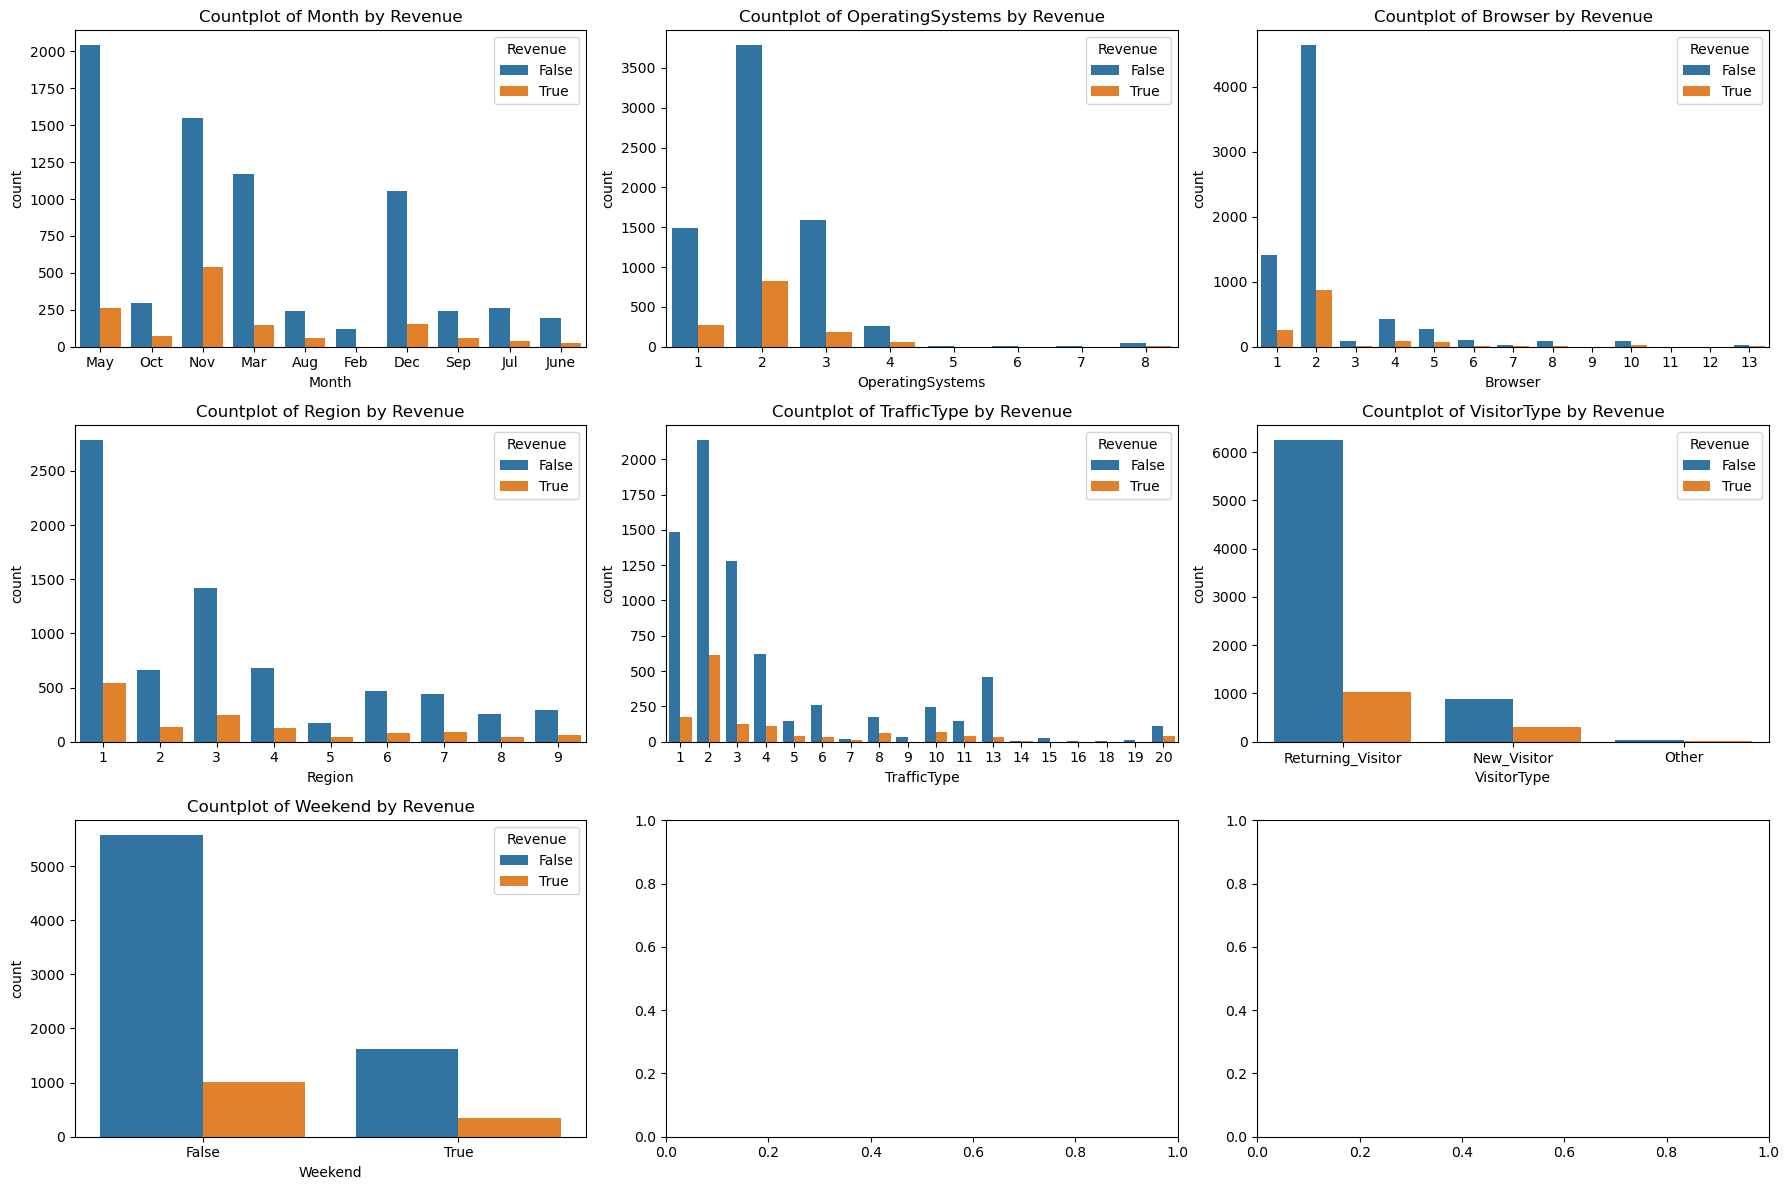

In [577]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=x_train[column], hue=y_train, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')

plt.tight_layout()
plt.show()

In [95]:
categories_to_combine1 = [4,5,6,7,8]
new_category_name1 = 4

X['OperatingSystems'] = X['OperatingSystems'].replace(categories_to_combine1, new_category_name1)
mapping1={
    1:'Windows',
    2:'Mac',
    3:'iOS',
    4:'Other'}
X['OperatingSystems']=X['OperatingSystems'].map(mapping1)


In [96]:
categories_to_combine2 = [3,4,5,6,7,8,9,10,11,12,13]
new_category_name2 = 3

X['Browser'] = X['Browser'].replace(categories_to_combine2, new_category_name2)
mapping2={
    1:'Chrome',
    2:'Safari',
    3:'Other'
}
X['Browser']=X['Browser'].map(mapping2)

categories_to_combine3 = [5,6,7,8,9,10,11,12,14,15,16,17,18,19,20]
new_category_name3 = 5

X['TrafficType'] = X['TrafficType'].replace(categories_to_combine3, new_category_name3)
mapping3={
    1:'SearchEngine',
    2:'Direct',
    3:'ReferringSites',
    4:'Paid',
    5:'Other',
    13:'Social'}
X['TrafficType']=X['TrafficType'].map(mapping3)


In [97]:
categories_to_combine4 = ['Oct','Nov','Dec']
new_category_name4 = 'Winter'

X['Month'] = X['Month'].replace(categories_to_combine4, new_category_name4)

categories_to_combine5 = ['May','June','Jul','Aug','Sep']
new_category_name5 = 'Summer'

X['Month'] = X['Month'].replace(categories_to_combine5, new_category_name5)

categories_to_combine6 = ['Feb','Mar']
new_category_name6 = 'Other'

X['Month'] = X['Month'].replace(categories_to_combine6, new_category_name6)

categories_to_combine7 = [5,6,7,8,9]
new_category_name7 = 5

X['Region'] = X['Region'].replace(categories_to_combine7, new_category_name7)
mapping4={
    1:'Region1',
    2:'Region2',
    3:'Region3',
    4:'Region4',
    5:'Region5'}
X['Region']=X['Region'].map(mapping4)

In [98]:
categories_to_combine8 = [0.2,0.4,0.6,0.8,1.0]
new_category_name8 = 1.0

X['SpecialDay'] = X['SpecialDay'].replace(categories_to_combine8, new_category_name8)



<Axes: xlabel='SpecialDay', ylabel='count'>

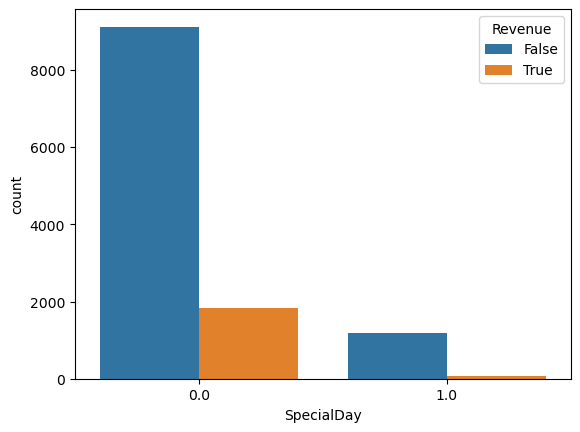

In [99]:
sns.countplot(x=X['SpecialDay'], hue=y)

In [100]:
mapping5={
    True:'Yes',
    False:'No'}
X['Weekend']=X['Weekend'].map(mapping5)

KeyError: 'Revenue'

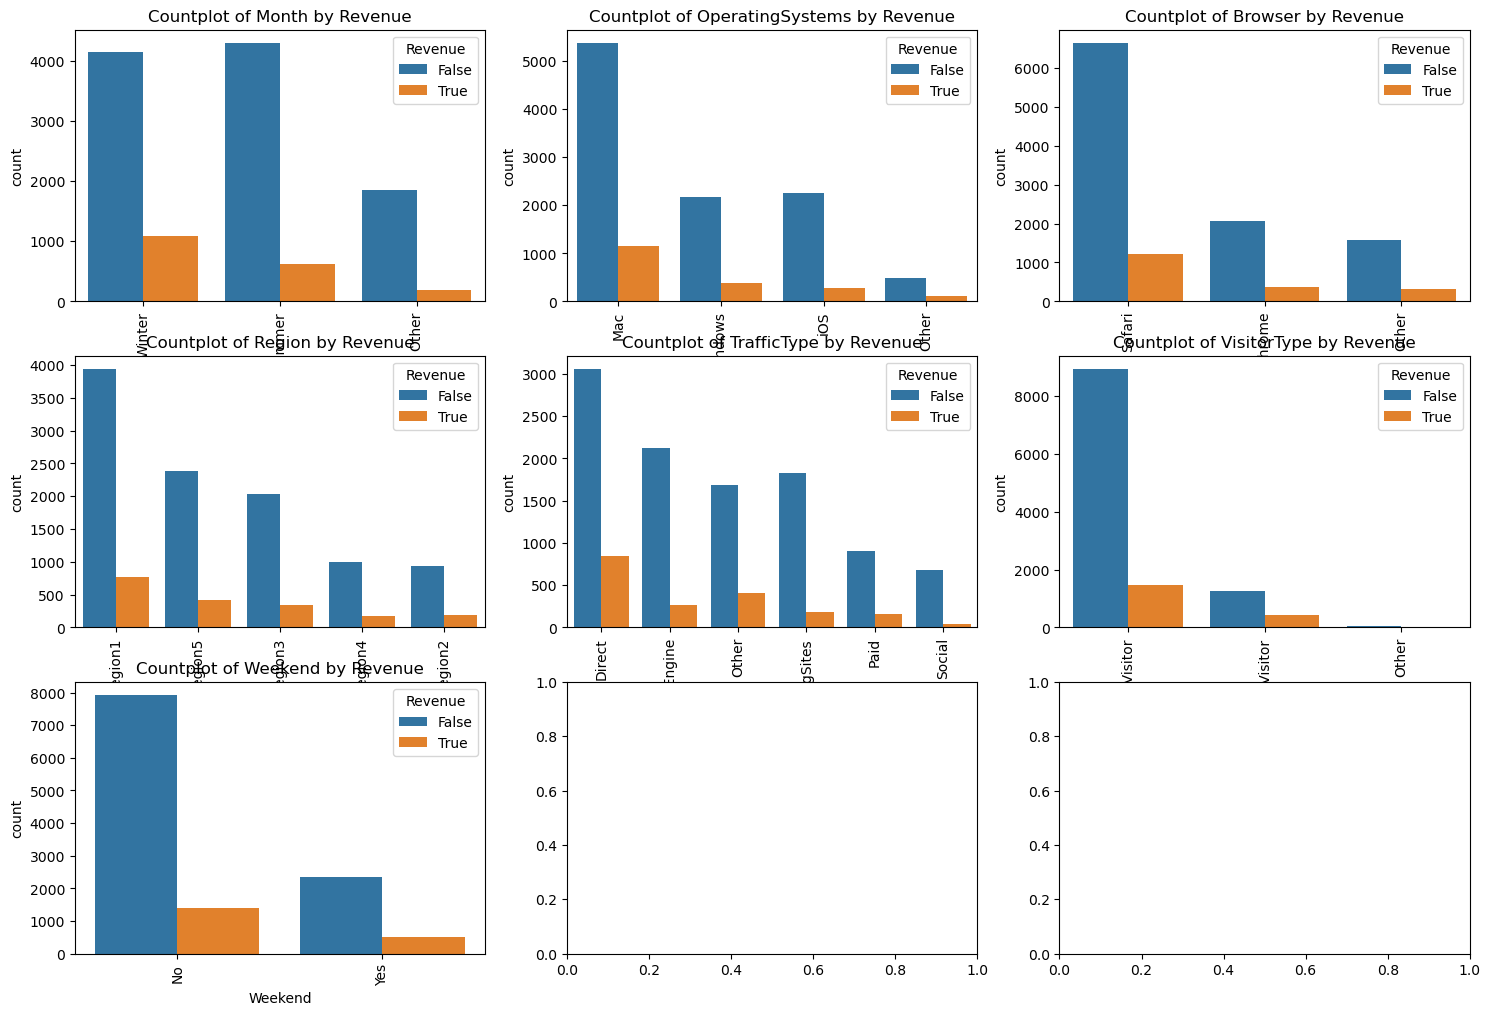

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=X[column], hue=y, ax=axes[i],order=X[column].value_counts().index)
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [102]:
X.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')


# advanced analysis


## advanced analysis without smote

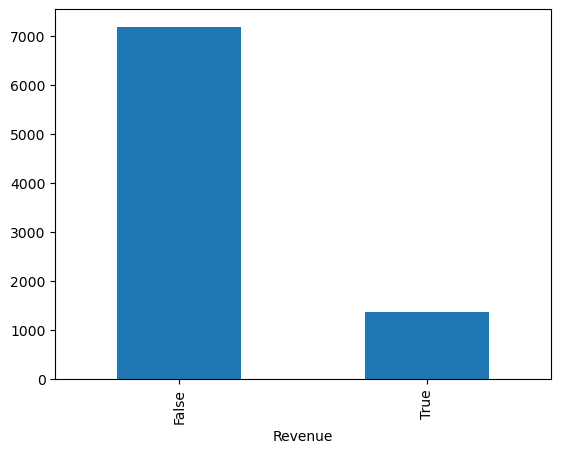

In [360]:
y_train.value_counts().plot(kind='bar')
plt.show()

### Random forest 

In [209]:
rfs = RandomForestClassifier()
rfs.fit(X_train, y_train)
eval_(rfs)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.90
Precision Score (Train set):1.00
Precision Score (Test set):0.71
Recall Score (Train set):0.82
Recall Score (Test set):0.56
F1 Score (Train set):0.90
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[7182    0]
 [1266 5916]]


In [210]:
rfs_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
#                   'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10]} 

In [211]:
rfs = RandomForestClassifier(random_state=42)
rfs_grid = GridSearchCV(rfs, param_grid = rfs_param_grid, cv = 3,scoring='roc_auc')

In [212]:
score=rfs_grid.fit(X_train,y_train)

In [213]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'n_estimators': 150}

In [214]:
best_rfs_grid=score.best_estimator_

In [215]:
eval_(best_rfs_grid)

Accuracy Score(Train set): 0.79
Accuracy Score(Test set): 0.90
Precision Score (Train set):0.96
Precision Score (Test set):0.73
Recall Score (Train set):0.60
Recall Score (Test set):0.54
F1 Score (Train set):0.74
F1 Score (Test set):0.62
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[7013  169]
 [2837 4345]]


In [217]:
from sklearn.metrics import roc_curve,auc
fpr9,tpr9,thresh=roc_curve(y_test,best_rfs_grid.predict(X_test))
auc9=auc(fpr9,tpr9)

## advanced analysis with smote

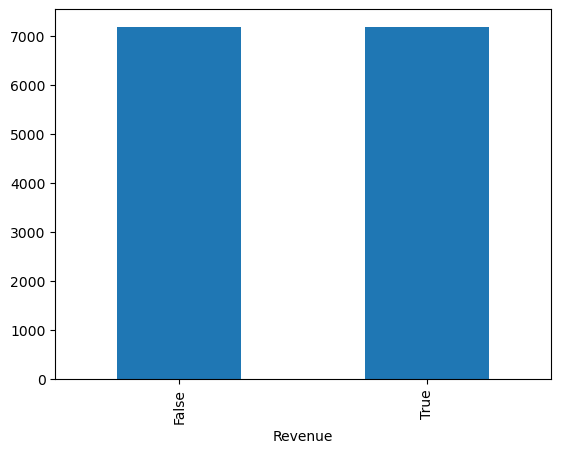

In [280]:
y_train_smote.value_counts().plot(kind='bar')
plt.show()

### Logistic Regression


In [334]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import shap

In [335]:
def eval_(model):
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train_smote)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred_proba_train = model.predict_proba(X_train_smote)[:,1]
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [336]:
X_train.columns

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Other', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [337]:
X_test.columns

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Other', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [338]:
logModel=LogisticRegression()
logModel.fit(X_train_smote,y_train_smote)

LogisticRegression()

In [339]:
eval_(logModel)

Accuracy Score(Train set): 0.82
Accuracy Score(Test set): 0.83
Precision Score (Train set):0.85
Precision Score (Test set):0.47
Recall Score (Train set):0.77
Recall Score (Test set):0.71
F1 Score (Train set):0.81
F1 Score (Test set):0.56
ROC AUC Score (Train-proba): 0.90
ROC AUC Score (Test-proba): 0.88
Confusion Matrix:
  [[6209  973]
 [1620 5562]]


#### Logistic regression - hyperparameter tuning

In [340]:
logModel.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [341]:
param_grid={'solver':['sag','saga','newton-cholesky'],
         'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'C':np.linspace(0.001, 0.2, 20),
         'max_iter' : [100, 300,500, 1000]}

In [342]:
logModel1=LogisticRegression()

In [343]:
log_grid = GridSearchCV(logModel1, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [344]:
score=log_grid.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [345]:
score.best_params_

{'C': 0.14763157894736842, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga'}

In [346]:
best_log_grid=score.best_estimator_

In [347]:
eval_(best_log_grid)

Accuracy Score(Train set): 0.82
Accuracy Score(Test set): 0.84
Precision Score (Train set):0.86
Precision Score (Test set):0.48
Recall Score (Train set):0.77
Recall Score (Test set):0.71
F1 Score (Train set):0.81
F1 Score (Test set):0.57
ROC AUC Score (Train-proba): 0.90
ROC AUC Score (Test-proba): 0.88
Confusion Matrix:
  [[6262  920]
 [1661 5521]]


<Axes: ylabel='Feature'>

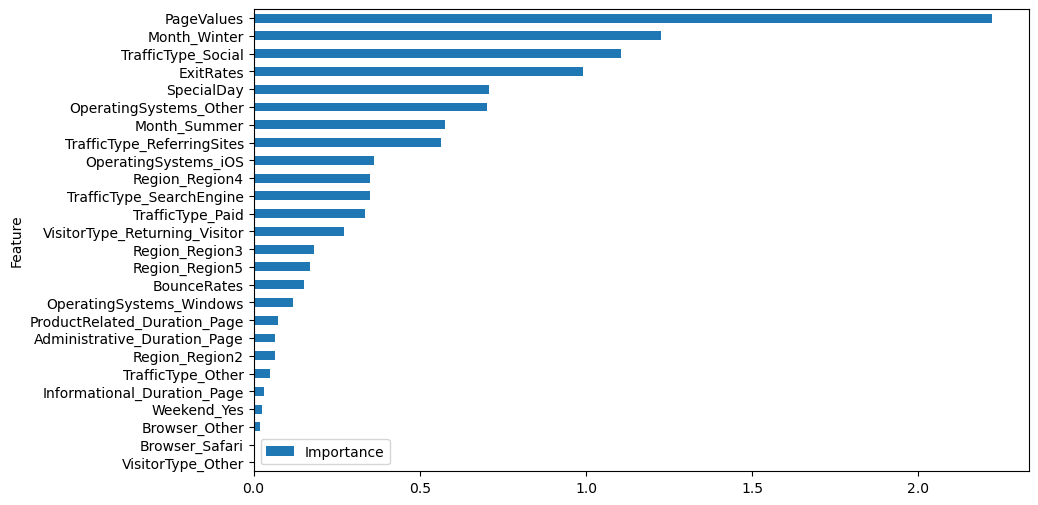

In [348]:
coefficients = best_log_grid.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train_smote.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

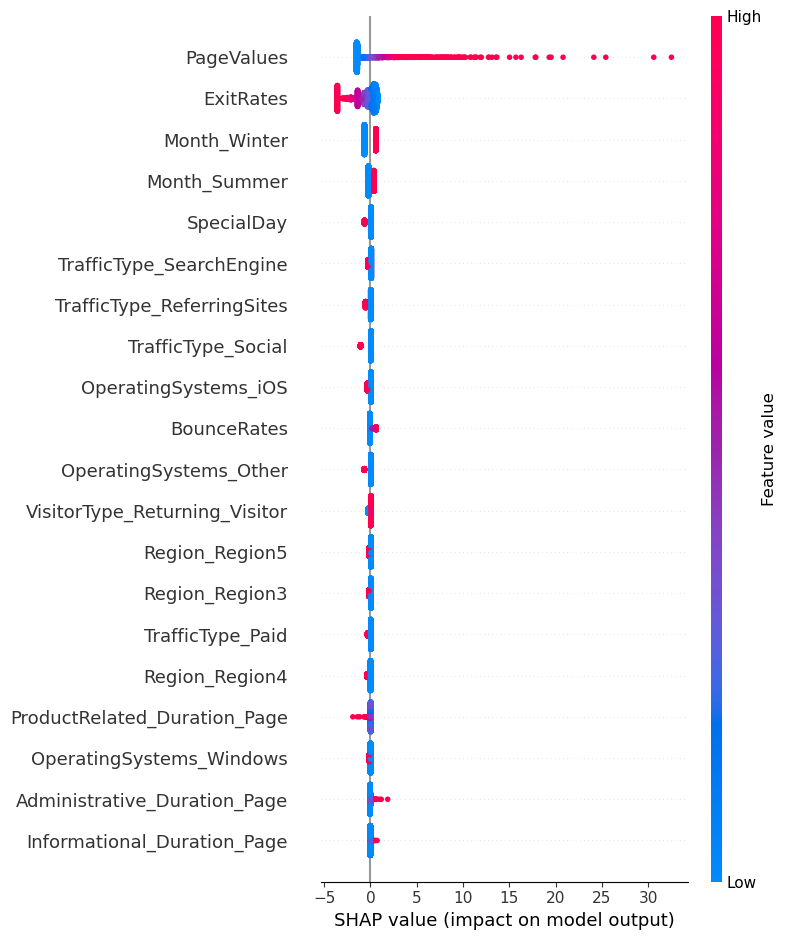

In [349]:
explainer = shap.LinearExplainer(best_log_grid, X_train_smote)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [350]:
from sklearn.metrics import roc_curve,auc
fpr1,tpr1,thresh=roc_curve(y_test,best_log_grid.predict_proba(X_test)[:,1])
auc1=auc(fpr1,tpr1)


### KNN

In [351]:
from sklearn.neighbors import KNeighborsClassifier

In [352]:
knn = KNeighborsClassifier()
knn.fit(X_train_smote, y_train_smote)
eval_(knn)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.78
Precision Score (Train set):0.87
Precision Score (Test set):0.37
Recall Score (Train set):0.99
Recall Score (Test set):0.68
F1 Score (Train set):0.93
F1 Score (Test set):0.48
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.80
Confusion Matrix:
  [[6128 1054]
 [  61 7121]]


In [353]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### KNN-hyperparameter tuning

In [354]:
param_grid={'n_neighbors': [5,10,50,100],
            'p' : [1,2],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
           }

In [355]:
knn1=KNeighborsClassifier()

In [356]:
knn_grid = GridSearchCV(knn1, param_grid = param_grid, cv = 3,scoring='roc_auc')

In [357]:
score=knn_grid.fit(X_train_smote,y_train_smote)

In [358]:
score.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1}

In [359]:
best_knn_grid=score.best_estimator_

In [360]:
eval_(best_knn_grid)

Accuracy Score(Train set): 0.94
Accuracy Score(Test set): 0.82
Precision Score (Train set):0.90
Precision Score (Test set):0.43
Recall Score (Train set):0.99
Recall Score (Test set):0.62
F1 Score (Train set):0.95
F1 Score (Test set):0.51
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.79
Confusion Matrix:
  [[6430  752]
 [  72 7110]]


In [103]:
# f = lambda x: best_knn_grid.predict_proba(x)[:, 1]
# med = X_train_smote.median().values.reshape((1, X_train_smote.shape[1]))

# explainer = shap.Explainer(f, med)
# shap_values = explainer(X_test.iloc[0:1000, :])
# shap.plots.beeswarm(shap_values)

In [361]:
fpr2,tpr2,thresh=roc_curve(y_test,best_knn_grid.predict_proba(X_test)[:,1])
auc2=auc(fpr2,tpr2)

### Random forest

In [362]:
from sklearn.ensemble import RandomForestClassifier

In [363]:
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)
eval_(rf)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.86
Precision Score (Train set):1.00
Precision Score (Test set):0.53
Recall Score (Train set):1.00
Recall Score (Test set):0.77
F1 Score (Train set):1.00
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


In [364]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Random Forest- Hyperparameter tuning

In [365]:
rf_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
                 'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10]} 

In [366]:
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, cv = 3,scoring='roc_auc')

In [367]:
score=rf_grid.fit(X_train_smote,y_train_smote)

In [368]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [369]:
best_rf_grid=score.best_estimator_

In [370]:
eval_(best_rf_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.52
Recall Score (Train set):0.91
Recall Score (Test set):0.80
F1 Score (Train set):0.91
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6453  729]
 [ 639 6543]]


In [590]:
eval_(best_rf_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.53
Recall Score (Train set):0.92
Recall Score (Test set):0.81
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6451  731]
 [ 546 6636]]


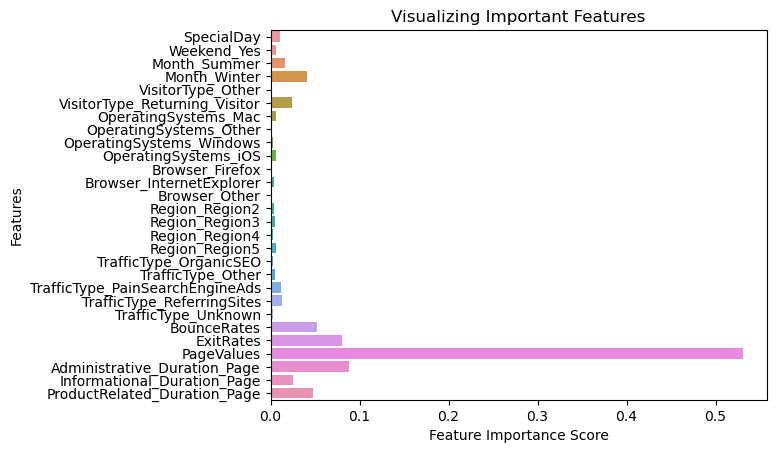

In [114]:
feature_imp1 = best_rf_grid.feature_importances_

sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [371]:
fpr3,tpr3,thresh=roc_curve(y_test,best_rf_grid.predict_proba(X_test)[:,1])
auc3=auc(fpr3,tpr3)

### Decision tree

In [372]:
from sklearn.tree import DecisionTreeClassifier

In [373]:
dt = DecisionTreeClassifier()
dt.fit(X_train_smote, y_train_smote)
eval_(dt)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.79
Precision Score (Train set):1.00
Precision Score (Test set):0.39
Recall Score (Train set):1.00
Recall Score (Test set):0.63
F1 Score (Train set):1.00
F1 Score (Test set):0.48
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.73
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


#### Decision tree-Hyperparameter tuning

In [374]:
dt_param_grid={
    'max_depth' :[5,6,10],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [2, 7] ,
    'max_features' : ['auto', 'sqrt'],
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}

In [375]:
dt = DecisionTreeClassifier(random_state = 42)
dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, cv = 3,scoring='roc_auc')

In [376]:
score=dt_grid.fit(X_train_smote,y_train_smote)

In [377]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'splitter': 'best'}

In [378]:
best_dt_grid=score.best_estimator_

In [379]:
eval_(best_dt_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.78
Precision Score (Train set):0.89
Precision Score (Test set):0.38
Recall Score (Train set):0.90
Recall Score (Test set):0.79
F1 Score (Train set):0.90
F1 Score (Test set):0.51
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.83
Confusion Matrix:
  [[6423  759]
 [ 722 6460]]


In [600]:
# eval_(best_dt_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.84
Precision Score (Train set):0.90
Precision Score (Test set):0.48
Recall Score (Train set):0.90
Recall Score (Test set):0.78
F1 Score (Train set):0.90
F1 Score (Test set):0.60
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6450  732]
 [ 693 6489]]


In [380]:
fpr4,tpr4,thresh=roc_curve(y_test,best_dt_grid.predict_proba(X_test)[:,1])
auc4=auc(fpr4,tpr4)

### AdaBoost

In [381]:
from sklearn.ensemble import AdaBoostClassifier

In [382]:
ab = AdaBoostClassifier()
ab.fit(X_train_smote, y_train_smote)
eval_(ab)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.89
Recall Score (Test set):0.74
F1 Score (Train set):0.89
F1 Score (Test set):0.62
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6469  713]
 [ 789 6393]]


In [383]:
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

#### AdaBoost - Hyperparameter Tuning -without base estimator

In [384]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200],   
}

In [385]:
ab = AdaBoostClassifier(random_state=42)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [386]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [387]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [388]:
best_ab_grid=score.best_estimator_

In [389]:
eval_(best_ab_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.91
Precision Score (Test set):0.52
Recall Score (Train set):0.91
Recall Score (Test set):0.74
F1 Score (Train set):0.91
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6527  655]
 [ 613 6569]]


In [609]:
# eval_(best_ab_grid)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.91
Precision Score (Test set):0.56
Recall Score (Train set):0.92
Recall Score (Test set):0.74
F1 Score (Train set):0.92
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6568  614]
 [ 577 6605]]


#### AdaBoost - Hyperparameter Tuning -with base estimator

In [134]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200]
}

In [135]:
dt_ada = DecisionTreeClassifier(random_state = 42,max_depth=6)
ab = AdaBoostClassifier(random_state=42,estimator=dt_ada)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [136]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [137]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [138]:
best_ab1_grid=score.best_estimator_

In [139]:
eval_(best_ab1_grid)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.86
Precision Score (Train set):1.00
Precision Score (Test set):0.54
Recall Score (Train set):1.00
Recall Score (Test set):0.70
F1 Score (Train set):1.00
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


In [140]:
fpr5,tpr5,thresh=roc_curve(y_test,best_ab_grid.predict_proba(X_test)[:,1])
auc5=auc(fpr5,tpr5)

### Gradient Boosting


In [390]:
from sklearn.ensemble import GradientBoostingClassifier

In [391]:
gb = GradientBoostingClassifier()
gb.fit(X_train_smote, y_train_smote)
eval_(gb)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.91
Precision Score (Test set):0.53
Recall Score (Train set):0.92
Recall Score (Test set):0.77
F1 Score (Train set):0.92
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6511  671]
 [ 557 6625]]


#### Gradient Boosting - Hyperparameter Tuning

In [442]:
# gb_param_grid={
#     'n_estimators':[50,100,150],
#     'max_depth':[4,5,6],
#     'max_features':['log2','sqrt',None],
#     #'min_samples_leaf': [2],
#     'learning_rate':[0.001,0.1,1],
#     'subsample':[0.5,0.6]
    
# }

gb_param_grid={
    'n_estimators':[200,400,500],
    'max_depth':[6],
    'max_features':['sqrt'],
    #'min_samples_leaf': [2],
    'learning_rate':[0.1],
    'subsample':[0.6]
    
}

In [443]:
gb= GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, cv = 3,scoring='roc_auc')

In [444]:
score=gb_grid.fit(X_train_smote,y_train_smote)

In [445]:
score.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'subsample': 0.6}

In [446]:
best_gb_grid=score.best_estimator_

In [447]:
eval_(best_gb_grid)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.86
Precision Score (Train set):1.00
Precision Score (Test set):0.53
Recall Score (Train set):1.00
Recall Score (Test set):0.70
F1 Score (Train set):1.00
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[7173    9]
 [  29 7153]]


In [618]:
# eval_(best_gb_grid)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.96
Precision Score (Test set):0.55
Recall Score (Train set):0.97
Recall Score (Test set):0.71
F1 Score (Train set):0.96
F1 Score (Test set):0.62
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[6868  314]
 [ 218 6964]]


In [448]:
fpr6,tpr6,thresh=roc_curve(y_test,best_gb_grid.predict_proba(X_test)[:,1])
auc6=auc(fpr6,tpr6)

### XGBoost 

In [399]:
from xgboost import XGBClassifier

In [400]:
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
eval_(xgb)

Accuracy Score(Train set): 0.98
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.98
Precision Score (Test set):0.54
Recall Score (Train set):0.98
Recall Score (Test set):0.70
F1 Score (Train set):0.98
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[7057  125]
 [ 125 7057]]


#### XGBoost - Hyperparameter Tuning

In [401]:
xgb_param_grid={
    'max_depth':[4,5,6],
    'n_estimators':[50,150,250],
    'colsample_bytree':[0.1,0.5,1],
    'learning_rate':[0.01,0.1,0.2],
    'subsample':[0.1]
    
}

In [402]:
xgb= XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, cv = 3,scoring='roc_auc')

In [403]:
score=xgb_grid.fit(X_train_smote,y_train_smote)

In [404]:
score.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 250,
 'subsample': 0.1}

In [405]:
best_xgb_grid=score.best_estimator_

In [406]:
eval_(best_xgb_grid)

Accuracy Score(Train set): 0.95
Accuracy Score(Test set): 0.85
Precision Score (Train set):0.94
Precision Score (Test set):0.49
Recall Score (Train set):0.96
Recall Score (Test set):0.72
F1 Score (Train set):0.95
F1 Score (Test set):0.59
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6762  420]
 [ 313 6869]]


In [658]:
# eval_(best_xgb_grid)

Accuracy Score(Train set): 0.95
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.94
Precision Score (Test set):0.52
Recall Score (Train set):0.96
Recall Score (Test set):0.72
F1 Score (Train set):0.95
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6752  430]
 [ 304 6878]]


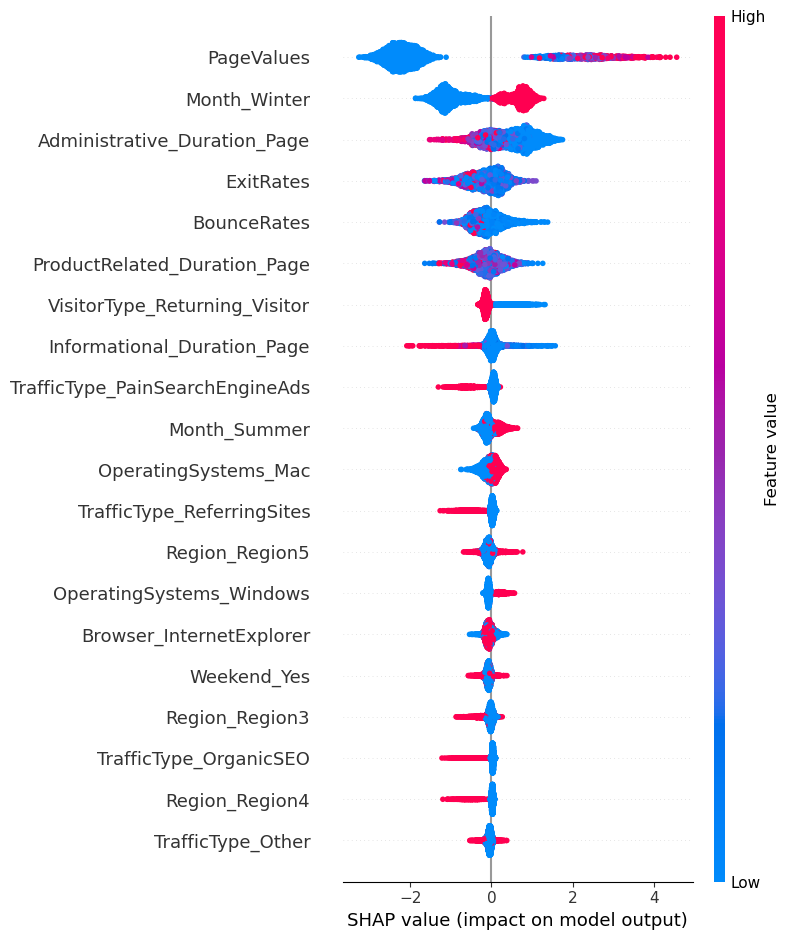

In [158]:
explainer = shap.TreeExplainer(best_xgb_grid)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [407]:
fpr7,tpr7,thresh=roc_curve(y_test,best_xgb_grid.predict_proba(X_test)[:,1])
auc7=auc(fpr7,tpr7)

### SVM

In [188]:
from sklearn.svm import SVC

In [189]:
svc = SVC(probability=True)
svc.fit(X_train_smote, y_train_smote)
eval_(svc)

Accuracy Score(Train set): 0.88
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.85
Recall Score (Test set):0.72
F1 Score (Train set):0.87
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 0.95
ROC AUC Score (Test-proba): 0.87
Confusion Matrix:
  [[6501  681]
 [1083 6099]]


In [190]:
svc_param_grid = {'C': [0.1, 1,10,100], 
              'gamma': [0.1,0.01,0.001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

In [191]:
svc= SVC(probability=True)
svc_grid = GridSearchCV(svc, param_grid = svc_param_grid, cv = 3,scoring='roc_auc')

In [192]:
score=svc_grid.fit(X_train_smote,y_train_smote)

KeyboardInterrupt: 

In [1032]:
score.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [1033]:
best_svc_grid=score.best_estimator_

In [1034]:
eval_(best_svc_grid)

Accuracy Score(Train set): 0.97
Accuracy Score(Test set): 0.85
Precision Score (Train set):0.96
Precision Score (Test set):0.50
Recall Score (Train set):0.98
Recall Score (Test set):0.58
F1 Score (Train set):0.97
F1 Score (Test set):0.54


AttributeError: predict_proba is not available when  probability=False

In [1036]:
fpr8,tpr8,thresh=roc_curve(y_test,best_svc_grid.predict(X_test))
auc8=auc(fpr8,tpr8)

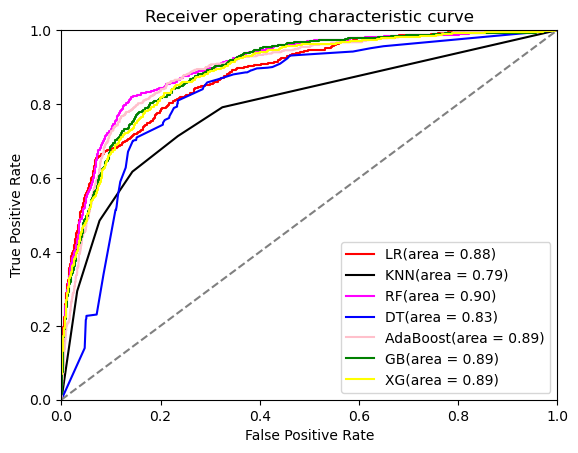

In [449]:
plt.plot(fpr1,tpr1, label='LR(area = %0.2f)' % auc1,color='red')
plt.plot(fpr2, tpr2, label='KNN(area = %0.2f)' % auc2,color='black')
plt.plot(fpr3, tpr3, label='RF(area = %0.2f)' % auc3,color='magenta')
plt.plot(fpr4, tpr4, label='DT(area = %0.2f)' % auc4,color='blue')
plt.plot(fpr5, tpr5, label='AdaBoost(area = %0.2f)' % auc5,color='pink')
plt.plot(fpr6, tpr6, label='GB(area = %0.2f)' % auc6,color='green')
plt.plot(fpr7, tpr7, label='XG(area = %0.2f)' % auc7,color='yellow')
#plt.plot(fpr8, tpr8, label='SVM(area = %0.2f)' % auc8,color='cyan')
#plt.plot(fpr9, tpr9, label='RF without smote(area = %0.2f)' % auc9,color='purple')
# plt.plot(fpr10, tpr10, label='RF with FS(area = %0.2f)' % auc10,color='cyan')
# plt.plot(fpr12, tpr12, label='XG with FS(area = %0.2f)' % auc12,color='purple')

plt.plot([0, 1], [0, 1], 'k--',color='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Feature selection

In [409]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier

In [410]:
#rfe=RFECV(estimator=ExtraTreesClassifier(),cv=5)
rfe=RFECV(estimator=ExtraTreesClassifier(),min_features_to_select=1,cv=5)

In [411]:
model=rfe.fit(X_train_smote,y_train_smote)

In [412]:
X_train_smote.columns[(model.get_support())].shape

(24,)

In [413]:
X_train_smote.columns[(model.get_support())]

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Returning_Visitor', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'Region_Region2', 'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [421]:
X_train_smote.columns[(model.get_support())]

Index(['SpecialDay', 'Weekend_Yes', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Rest', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Windows', 'OperatingSystems_iOS', 'Browser_Other',
       'Browser_Safari', 'Region_Region2', 'Region_Region3', 'Region_Region4',
       'Region_Region5', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [414]:
# selCols=['Weekend_Yes', 'Month_Summer', 'Month_Winter',
#        'VisitorType_Returning_Visitor', 'OperatingSystems_Mac',
#        'OperatingSystems_Windows', 'OperatingSystems_iOS',
#        'Browser_InternetExplorer', 'Browser_Other',
#        'TrafficType_OrganicSEO', 'TrafficType_Other',
#        'TrafficType_PainSearchEngineAds', 'TrafficType_ReferringSites',
#        'BounceRates', 'ExitRates', 'PageValues',
#        'Administrative_Duration_Page', 'Informational_Duration_Page',
#        'ProductRelated_Duration_Page']
selCols=['Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Returning_Visitor', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page']

In [415]:
X_train_smote_new=X_train_smote[selCols].copy()

In [416]:
y_train_smote.shape

(14364,)

In [417]:
X_test_new=X_test[selCols].copy()

In [418]:
X_test_new.columns

Index(['Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Returning_Visitor', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Other', 'Browser_Safari',
       'TrafficType_Other', 'TrafficType_Paid', 'TrafficType_ReferringSites',
       'TrafficType_SearchEngine', 'TrafficType_Social', 'BounceRates',
       'ExitRates', 'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [419]:
X_test_new.shape

(3660, 19)

## Logistic Regression with features selected

In [452]:
param_grid={'solver':['sag','saga','newton-cholesky'],
         'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'C':np.linspace(0.001, 0.2, 20),
         'max_iter' : [100, 300,500, 1000]}
logModel1=LogisticRegression()
log_grid = GridSearchCV(logModel1, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [453]:
score=log_grid.fit(X_train_smote_new,y_train_smote)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [454]:
score.best_params_

{'C': 0.001, 'max_iter': 100, 'penalty': 'none', 'solver': 'sag'}

In [457]:
best_log_grid=score.best_estimator_
evalNew(best_log_grid)

Accuracy Score(Train set): 0.83
Accuracy Score(Test set): 0.84
Precision Score (Train set):0.85
Precision Score (Test set):0.49
Recall Score (Train set):0.80
Recall Score (Test set):0.78
F1 Score (Train set):0.82
F1 Score (Test set):0.60
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6138 1044]
 [1453 5729]]


In [458]:
fpr1,tpr1,thresh=roc_curve(y_test,best_log_grid.predict_proba(X_test_new)[:,1])
auc1=auc(fpr1,tpr1)

## KNN

In [459]:
param_grid={'n_neighbors': [5,10,50,100],
            'p' : [1,2],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
           }
knn1=KNeighborsClassifier()
knn_grid = GridSearchCV(knn1, param_grid = param_grid, cv = 3,scoring='roc_auc')

In [460]:
score=knn_grid.fit(X_train_smote_new,y_train_smote)

In [461]:
score.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}

In [462]:
best_knn_grid=score.best_estimator_
evalNew(best_knn_grid)

Accuracy Score(Train set): 0.95
Accuracy Score(Test set): 0.82
Precision Score (Train set):0.91
Precision Score (Test set):0.43
Recall Score (Train set):0.99
Recall Score (Test set):0.60
F1 Score (Train set):0.95
F1 Score (Test set):0.50
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.80
Confusion Matrix:
  [[6499  683]
 [  59 7123]]


In [463]:
fpr2,tpr2,thresh=roc_curve(y_test,best_knn_grid.predict_proba(X_test_new)[:,1])
auc2=auc(fpr2,tpr2)

## Decision Tree

In [466]:
dt_param_grid={
    'max_depth' :[5,6,10],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [2, 7] ,
    'max_features' : ['auto', 'sqrt'],
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}
dt = DecisionTreeClassifier(random_state = 42)
dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, cv = 3,scoring='roc_auc')

In [467]:
score=dt_grid.fit(X_train_smote_new,y_train_smote)

In [468]:
score.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'splitter': 'best'}

In [469]:
best_dt_grid=score.best_estimator_
evalNew(best_dt_grid)

Accuracy Score(Train set): 0.88
Accuracy Score(Test set): 0.82
Precision Score (Train set):0.89
Precision Score (Test set):0.45
Recall Score (Train set):0.88
Recall Score (Test set):0.71
F1 Score (Train set):0.88
F1 Score (Test set):0.55
ROC AUC Score (Train-proba): 0.95
ROC AUC Score (Test-proba): 0.86
Confusion Matrix:
  [[6361  821]
 [ 842 6340]]


In [470]:
fpr4,tpr4,thresh=roc_curve(y_test,best_dt_grid.predict_proba(X_test_new)[:,1])
auc4=auc(fpr4,tpr4)

## adaboost

In [471]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200],   
}

In [472]:
ab = AdaBoostClassifier(random_state=42)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [473]:
score=ab_grid.fit(X_train_smote_new,y_train_smote)

In [474]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [475]:
best_ab_grid=score.best_estimator_
evalNew(best_ab_grid)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.91
Precision Score (Test set):0.56
Recall Score (Train set):0.92
Recall Score (Test set):0.74
F1 Score (Train set):0.92
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6558  624]
 [ 575 6607]]


In [476]:
fpr5,tpr5,thresh=roc_curve(y_test,best_ab_grid.predict_proba(X_test_new)[:,1])
auc5=auc(fpr5,tpr5)

### Gradient Boosting with features selected

In [507]:
gb_param_grid={
    'n_estimators':[50,100,150],
    'max_depth':[4,5,6],
    'max_features':['log2','sqrt',None],
    #'min_samples_leaf': [2],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}
gb= GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, cv = 3,scoring='roc_auc')

In [508]:
score=gb_grid.fit(X_train_smote_new,y_train_smote)

In [510]:
score.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 150,
 'subsample': 0.6}

In [511]:
best_gb_grid=score.best_estimator_
evalNew(best_gb_grid)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.96
Precision Score (Test set):0.56
Recall Score (Train set):0.97
Recall Score (Test set):0.72
F1 Score (Train set):0.96
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[6862  320]
 [ 222 6960]]


In [442]:
gbm.fit(X_train_smote_new,y_train_smote)


GradientBoostingClassifier(max_depth=6, max_features='log2', n_estimators=150,
                           random_state=42, subsample=0.6)

In [172]:
def evalNew(model):
    y_pred=model.predict(X_test_new)
    y_pred_train=model.predict(X_train_smote_new)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test_new)
    y_pred_proba_train = model.predict_proba(X_train_smote_new)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [444]:
evalNew(gbm)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.96
Precision Score (Test set):0.56
Recall Score (Train set):0.97
Recall Score (Test set):0.72
F1 Score (Train set):0.96
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[6862  320]
 [ 222 6960]]


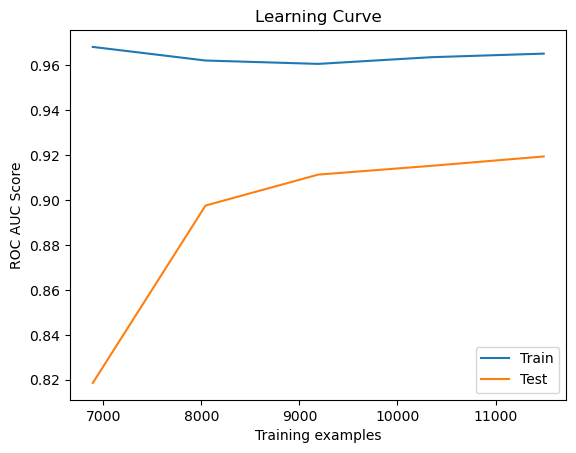

In [320]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

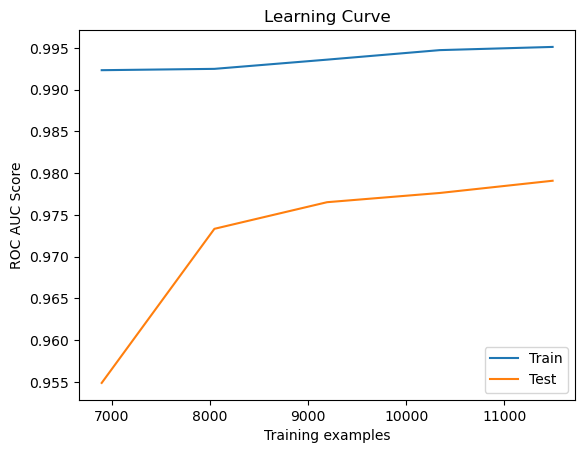

In [321]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [512]:
fpr11,tpr11,thresh=roc_curve(y_test,best_gb_grid.predict_proba(X_test_new)[:,1])
auc11=auc(fpr11,tpr11)

### XGBoosting with feature selected

In [495]:
xgb_param_grid={
    'max_depth':[4,5,6],
    'n_estimators':[100,200,300],
    'colsample_bytree':[0.1,0.5,1],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}
xgb= XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, cv = 3,scoring='roc_auc')

In [496]:
score=xgb_grid.fit(X_train_smote_new,y_train_smote)

In [497]:
score.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 300,
 'subsample': 0.6}

In [498]:
best_xgb_grid=score.best_estimator_
evalNew(best_xgb_grid)

Accuracy Score(Train set): 0.99
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.99
Precision Score (Test set):0.54
Recall Score (Train set):0.99
Recall Score (Test set):0.69
F1 Score (Train set):0.99
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[7093   89]
 [  91 7091]]


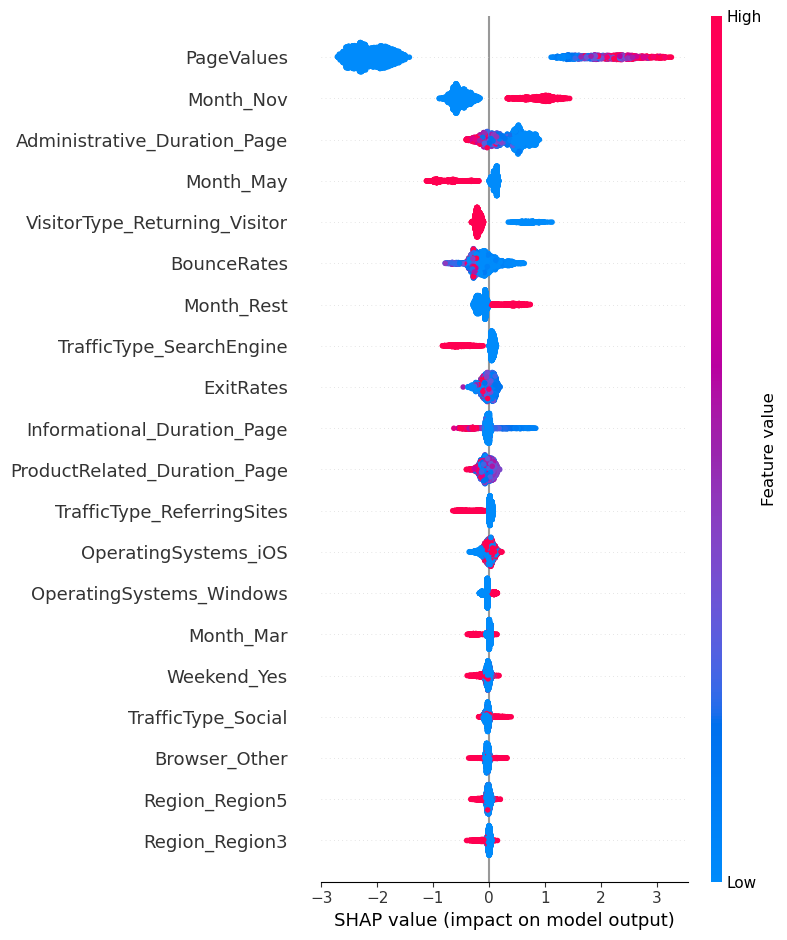

In [438]:
explainer = shap.TreeExplainer(xgm)
shap_values = explainer.shap_values(X_test_new)
shap.summary_plot(shap_values, X_test_new)

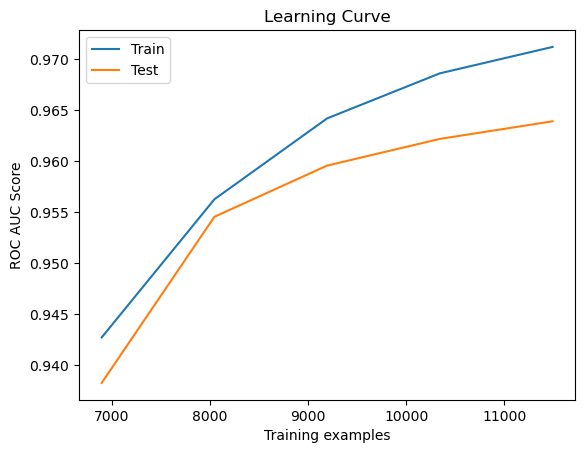

In [327]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

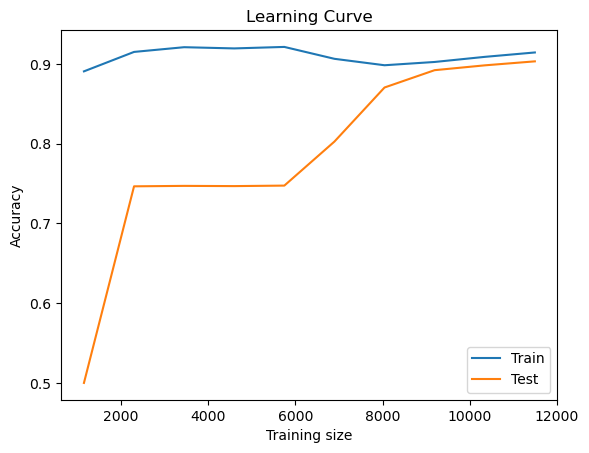

In [328]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [1190]:
# from sklearn.inspection import PartialDependenceDisplay
# fig, ax = plt.subplots(figsize=(20,20 ))
# ax.set_title("Partial Dependence Plots")
# PartialDependenceDisplay.from_estimator(
#     estimator=xgm,
#     X=X_test_new,
#     features=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12),
#     random_state=5,
#     ax=ax,
# )
# plt.show()

In [502]:
fpr12,tpr12,thresh=roc_curve(y_test,best_xgb_grid.predict_proba(X_test_new)[:,1])
auc12=auc(fpr12,tpr12)

### Random Forest with features selected

In [420]:
rfn_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
                 'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10]} 
rfn = RandomForestClassifier(random_state=42)
rfn_grid = GridSearchCV(rfn, param_grid = rfn_param_grid, cv = 3,scoring='roc_auc')

In [421]:
scoreN=rfn_grid.fit(X_train_smote_new,y_train_smote)

In [422]:
scoreN.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 150}

In [423]:
best_rfn_grid=scoreN.best_estimator_
evalNew(best_rfn_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.52
Recall Score (Train set):0.91
Recall Score (Test set):0.80
F1 Score (Train set):0.91
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6438  744]
 [ 616 6566]]


In [676]:
best_rfn_grid=scoreN.best_estimator_
evalNew(best_rfn_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.52
Recall Score (Train set):0.93
Recall Score (Test set):0.80
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6453  729]
 [ 527 6655]]


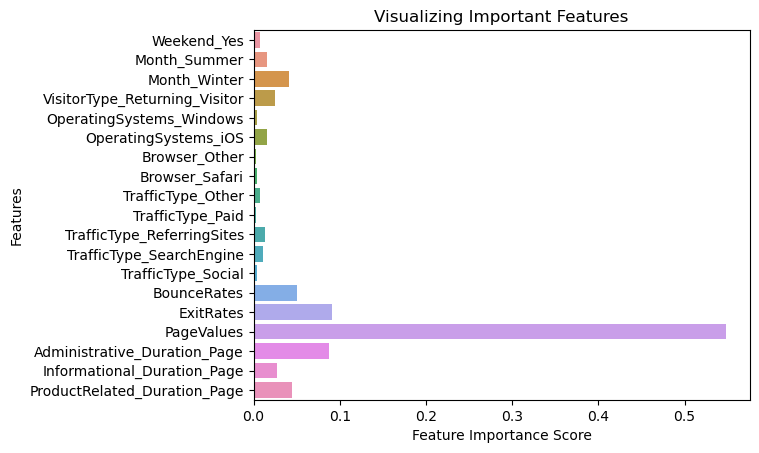

In [424]:
feature_imp1 = best_rfn_grid.feature_importances_

sns.barplot(x=feature_imp1, y=X_test_new.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

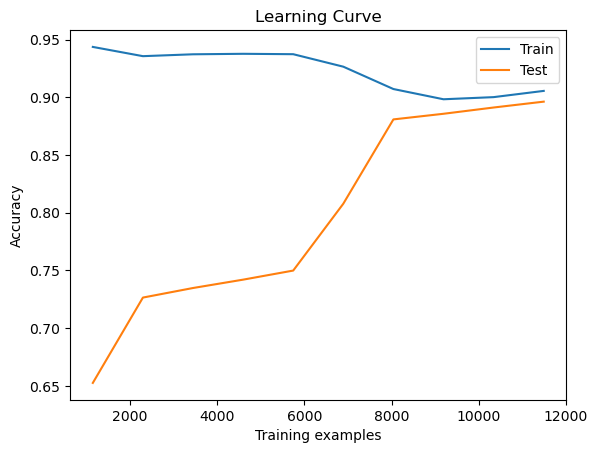

In [436]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rfn_grid,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

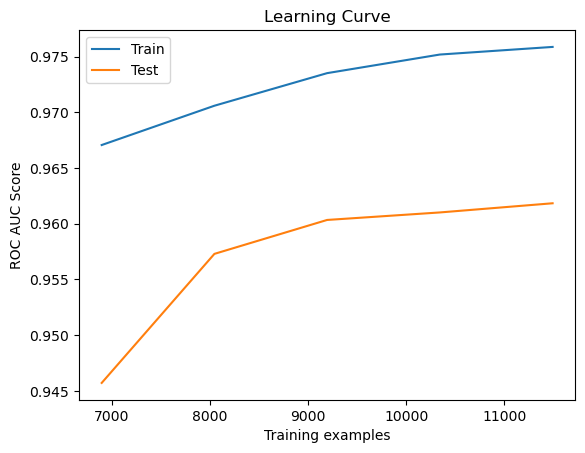

In [425]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rfn_grid,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [426]:
X_train_smote_new.shape

(14364, 19)

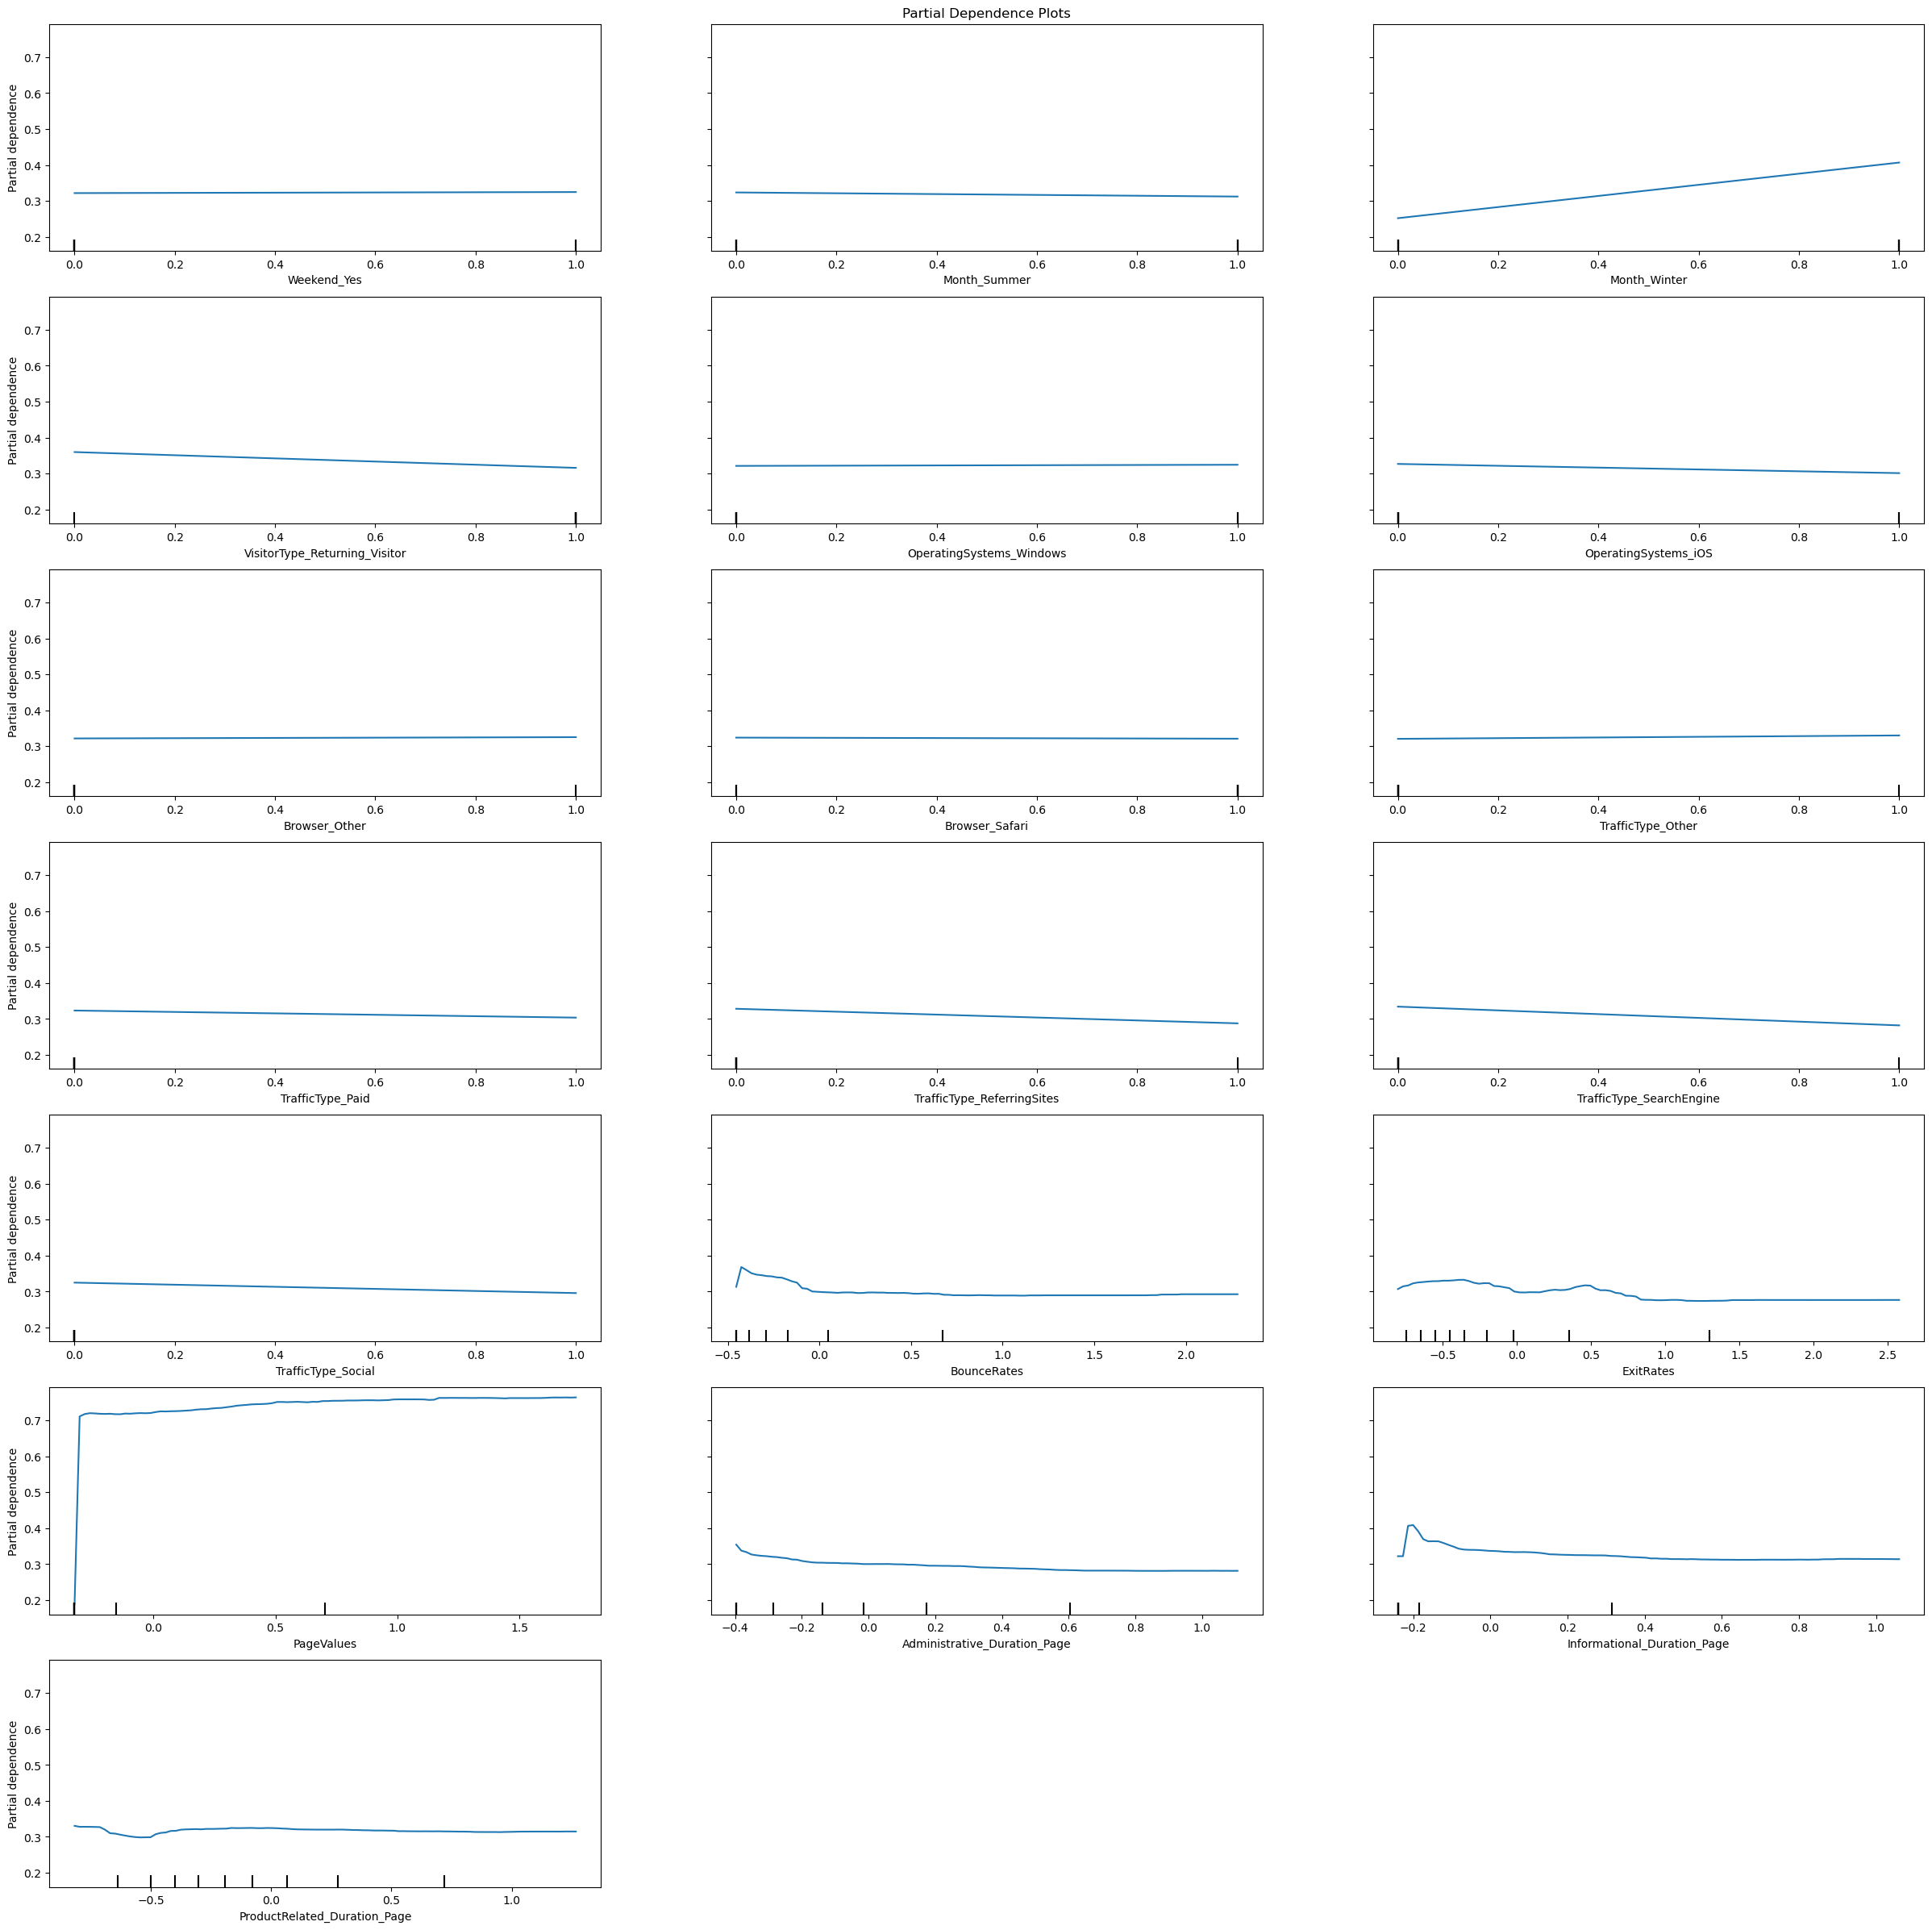

In [435]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(30,30))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=best_rfn_grid,
    X=X_test_new,
    features=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18),
    random_state=5,
    ax=ax,
)
plt.show()

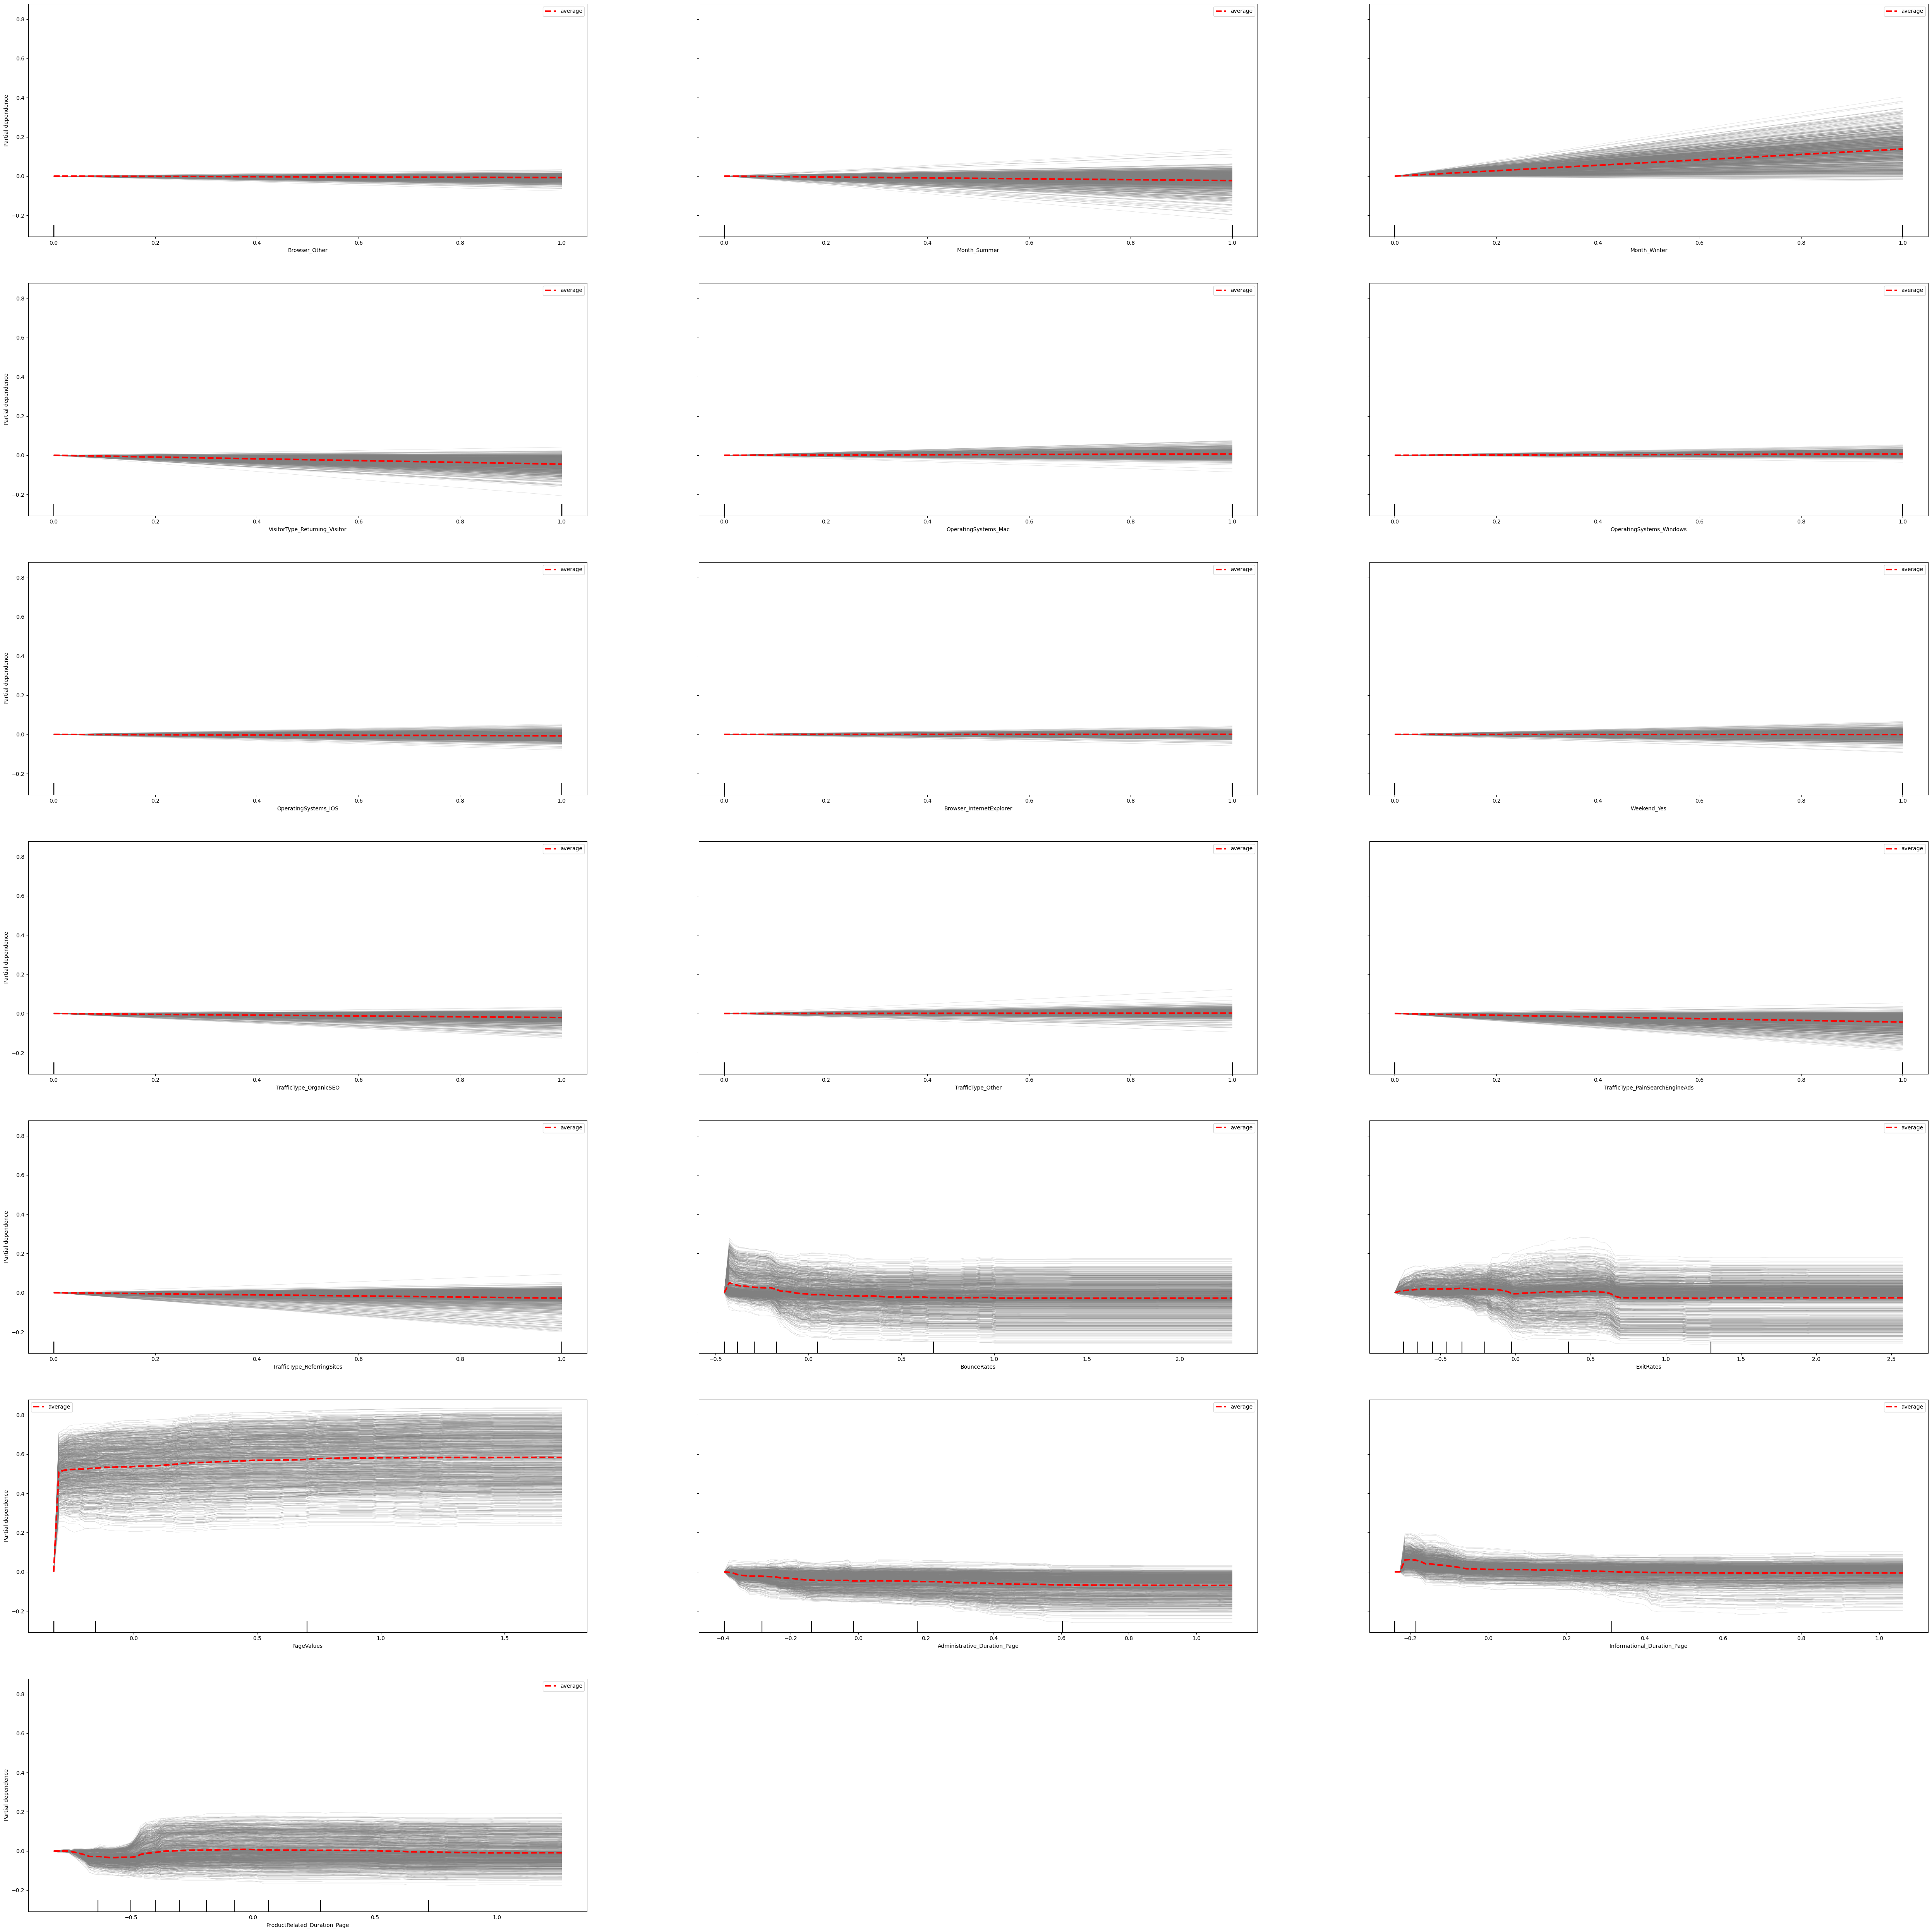

In [180]:
from sklearn.inspection import PartialDependenceDisplay
cols = X_test_new.columns
included_features_indices = np.argpartition(best_rfn_grid.feature_importances_, -19)[-19:]

fig, ax = plt.subplots(figsize=(50, 50))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=best_rfn_grid,
                                            ax=ax,
                                            X=X_test_new,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

In [504]:
fpr10,tpr10,thresh=roc_curve(y_test,best_rf_grid.predict_proba(X_test_new)[:,1])
auc10=auc(fpr10,tpr10)

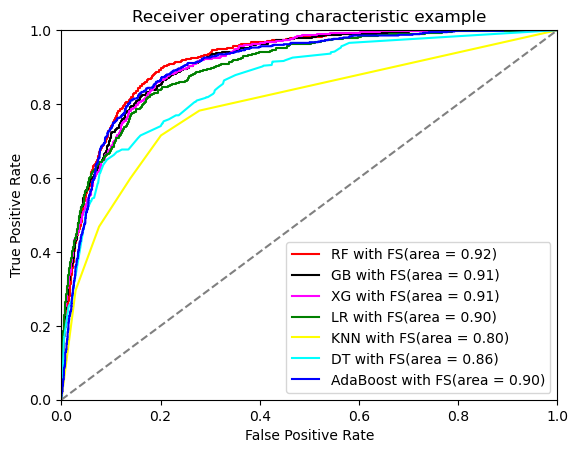

In [513]:
plt.plot(fpr10,tpr10, label='RF with FS(area = %0.2f)' % auc10,color='red')
plt.plot(fpr11, tpr11, label='GB with FS(area = %0.2f)' % auc11,color='black')
plt.plot(fpr12, tpr12, label='XG with FS(area = %0.2f)' % auc12,color='magenta')
plt.plot(fpr1,tpr1, label='LR with FS(area = %0.2f)' % auc1,color='green')
plt.plot(fpr2, tpr2, label='KNN with FS(area = %0.2f)' % auc2,color='yellow')
plt.plot(fpr4, tpr4, label='DT with FS(area = %0.2f)' % auc4,color='cyan')
plt.plot(fpr5, tpr5, label='AdaBoost with FS(area = %0.2f)' % auc5,color='blue')



plt.plot([0, 1], [0, 1], 'k--',color='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [680]:
X_test_new.shape

(3660, 24)

## feature selection new

In [181]:
from sklearn.feature_selection import SelectFromModel

In [182]:
from sklearn.linear_model import LassoCV
embeded_lasso_selector = SelectFromModel(LassoCV(random_state = 123, cv = 10, max_iter = 2000),threshold = 0.0001)
embeded_lasso_selector.fit(X_train_smote, y_train_smote)

SelectFromModel(estimator=LassoCV(cv=10, max_iter=2000, random_state=123),
                threshold=0.0001)

In [183]:
embeded_lasso_support = embeded_lasso_selector.get_support()
embeded_lasso_feature = X_train_smote.loc[:,embeded_lasso_support].columns.tolist()
print(str(len(embeded_lasso_feature)), 'selected features')

26 selected features


In [184]:
X_train_smote.columns[(embeded_lasso_selector.get_support())]

Index(['SpecialDay', 'Weekend_Yes', 'Month_Summer', 'Month_Winter',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_Mac', 'OperatingSystems_Other',
       'OperatingSystems_Windows', 'OperatingSystems_iOS',
       'Browser_InternetExplorer', 'Browser_Other', 'Region_Region2',
       'Region_Region3', 'Region_Region4', 'Region_Region5',
       'TrafficType_OrganicSEO', 'TrafficType_Other',
       'TrafficType_PainSearchEngineAds', 'TrafficType_ReferringSites',
       'TrafficType_Unknown', 'BounceRates', 'ExitRates', 'PageValues',
       'Administrative_Duration_Page', 'Informational_Duration_Page'],
      dtype='object')

In [185]:
from sklearn.linear_model import RidgeClassifierCV
embeded_ridge_selector = SelectFromModel(RidgeClassifierCV(cv=10), threshold =0.059)
embeded_ridge_selector.fit(X_train_smote, y_train_smote)

SelectFromModel(estimator=RidgeClassifierCV(cv=10), threshold=0.059)

In [186]:
embeded_ridge_support = embeded_ridge_selector.get_support()
embeded_ridge_feature = X_train_smote.loc[:,embeded_ridge_support].columns.tolist()
print(str(len(embeded_ridge_feature)), 'selected features')

18 selected features


In [187]:
X_train_smote.columns[(embeded_ridge_selector.get_support())]

Index(['SpecialDay', 'Month_Summer', 'Month_Winter', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'OperatingSystems_Mac',
       'OperatingSystems_Other', 'Browser_Other', 'Region_Region3',
       'Region_Region4', 'Region_Region5', 'TrafficType_OrganicSEO',
       'TrafficType_PainSearchEngineAds', 'TrafficType_ReferringSites',
       'TrafficType_Unknown', 'BounceRates', 'ExitRates', 'PageValues'],
      dtype='object')